## Using the small MovieLens data set, create a recommender system that allows users to input a movie they like (in the data set) and recommends ten other movies for them to watch. In your write-up, clearly explain the recommender system process and all steps performed. If you are using a method found online, be sure to reference the source.

In [1]:
# Import Libraries
library(readr)
library(ggplot2)
library(data.table)
library(reshape2)
library("recommenderlab")
library("arules")

Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'data.table' was built under R version 3.6.3"Warning message:
"package 'reshape2' was built under R version 3.6.3"
Attaching package: 'reshape2'

The following objects are masked from 'package:data.table':

    dcast, melt

Warning message:
"package 'recommenderlab' was built under R version 3.6.3"Loading required package: Matrix
Warning message:
"package 'Matrix' was built under R version 3.6.3"Loading required package: arules

Attaching package: 'arules'

The following objects are masked from 'package:base':

    abbreviate, write

Loading required package: proxy
Warning message:
"package 'proxy' was built under R version 3.6.3"
Attaching package: 'proxy'

The following object is masked from 'package:Matrix':

    as.matrix

The following objects are masked from 'package:stats':

    as.dist, dist

The following object is masked from 'package:base':

    as.matrix

Loading required package: re

In [2]:
# Import the CSV datasets
ratings_data <- read_csv("C:/Users/kadams/Downloads/DSC 630/ratings.csv")
movie_data <- read_csv("C:/Users/kadams/Downloads/DSC 630/movies.csv")


-- Column specification --------------------------------------------------------
cols(
  userId = col_double(),
  movieId = col_double(),
  rating = col_double(),
  timestamp = col_double()
)


-- Column specification --------------------------------------------------------
cols(
  movieId = col_double(),
  title = col_character(),
  genres = col_character()
)



In [3]:
# Convert the genres present in the movie_data dataframe into a more usable format by the users.
movie_genre <- as.data.frame(movie_data$genres, stringsAsFactors=FALSE)
movie_genre2 <- as.data.frame(tstrsplit(movie_genre[,1], '[|]', type.convert=TRUE), stringsAsFactors=FALSE)
colnames(movie_genre2) <- c(1:10)

list_genre <- c("Action", "Adventure", "Animation", "Children", "Comedy", "Crime","Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery","Romance", "Sci-Fi", "Thriller", "War", "Western")
genre_mat1 <- matrix(0,nrow(movie_genre)+1,18)
genre_mat1[1,] <- list_genre
colnames(genre_mat1) <- list_genre
for (index in 1:nrow(movie_genre2)) {
  for (col in 1:ncol(movie_genre2)) {
    gen_col = which(genre_mat1[1,] == movie_genre2[index,col]) 
    genre_mat1[index+1,gen_col] <- 1
}
}
genre_mat2 <- as.data.frame(genre_mat1[-1,], stringsAsFactors=FALSE) 
for (col in 1:ncol(genre_mat2)) {
  genre_mat2[,col] <- as.integer(genre_mat2[,col]) #convert from characters to integers
} 

In [4]:
# Create a "search matrix" to allow easy search of the films by specifying the genre in the list
SearchMatrix <- cbind(movie_data[,1:2], genre_mat2[])

In [5]:
# Covert matrix into a sparse matrix
ratingMatrix <- dcast(ratings_data, userId~movieId, value.var = "rating", na.rm=FALSE)
ratingMatrix <- as.matrix(ratingMatrix[,-1])
ratingMatrix <- as(ratingMatrix, "realRatingMatrix")

In [6]:
recommendation_model <- recommenderRegistry$get_entries(dataType = "realRatingMatrix")

In [7]:
lapply(recommendation_model, "[[", "description")

$HYBRID_realRatingMatrix
[1] "Hybrid recommender that aggegates several recommendation strategies using weighted averages."

$ALS_realRatingMatrix
[1] "Recommender for explicit ratings based on latent factors, calculated by alternating least squares algorithm."

$ALS_implicit_realRatingMatrix
[1] "Recommender for implicit data based on latent factors, calculated by alternating least squares algorithm."

$IBCF_realRatingMatrix
[1] "Recommender based on item-based collaborative filtering."

$LIBMF_realRatingMatrix
[1] "Matrix factorization with LIBMF via package recosystem (https://cran.r-project.org/web/packages/recosystem/vignettes/introduction.html)."

$POPULAR_realRatingMatrix
[1] "Recommender based on item popularity."

$RANDOM_realRatingMatrix
[1] "Produce random recommendations (real ratings)."

$RERECOMMEND_realRatingMatrix
[1] "Re-recommends highly rated items (real ratings)."

$SVD_realRatingMatrix
[1] "Recommender based on SVD approximation with column-mean imputation."

$SVDF_realRatingMatrix
[1] "Recommender based on Funk SVD with gradient descend (https://sifter.org/~simon/journal/20061211.html)."

$UBCF_realRatingMatrix
[1] "Recommender based on user-based collaborative filtering."

In [8]:
recommendation_model$IBCF_realRatingMatrix$parameters

$k
[1] 30

$method
[1] "Cosine"

$normalize
[1] "center"

$normalize_sim_matrix
[1] FALSE

$alpha
[1] 0.5

$na_as_zero
[1] FALSE

1,2,3,4
0.0000000,1,0.7919033,0.9328096
1.0000000,0,NA,1.0000000
0.7919033,NA,0.0000000,1.0000000
0.9328096,1,1.0000000,0.0000000


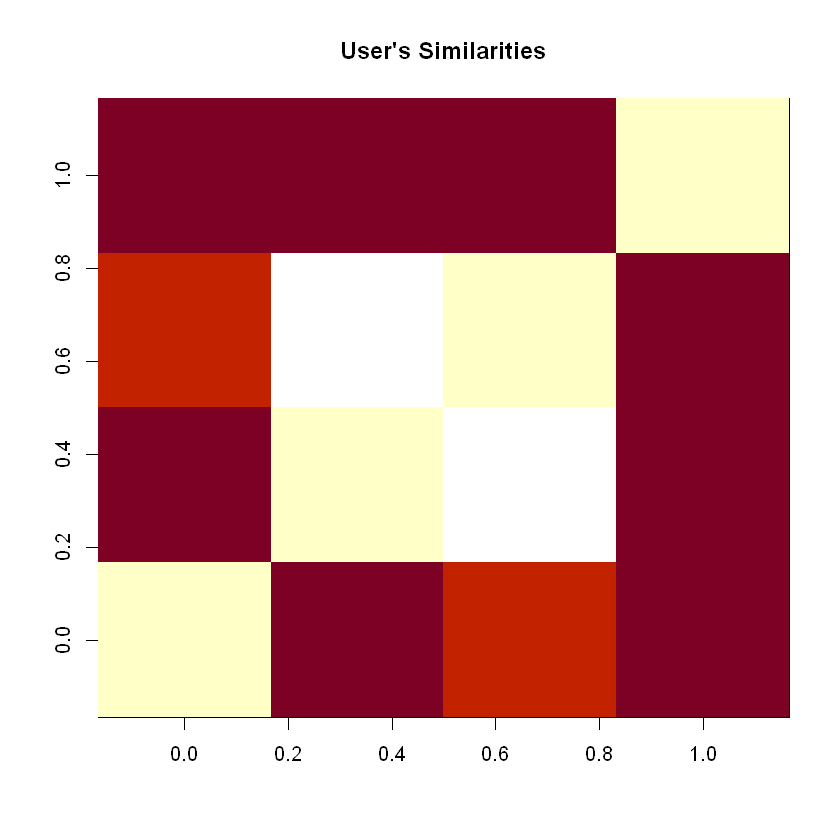

In [9]:
# Compute the similarities using various operators like cosine, person and jaccard
similarity_mat <- similarity(ratingMatrix[1:4, ],method = "cosine",which = "users")
as.matrix(similarity_mat)
image(as.matrix(similarity_mat), main = "User's Similarities")

1,2,3,4
0.0000000,0.9644641,0.9715415,0.9838699
0.9644641,0.0000000,0.9389013,0.9609877
0.9715415,0.9389013,0.0000000,1.0000000
0.9838699,0.9609877,1.0000000,0.0000000


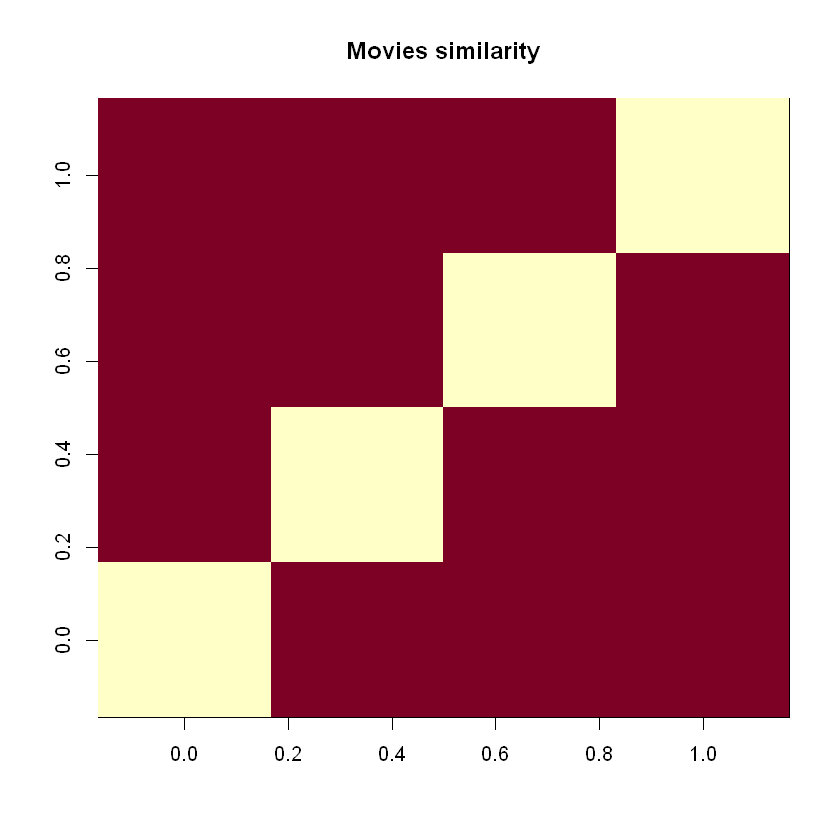

In [10]:
# Delineate the similariy that is shared between the films
movie_similarity <- similarity(ratingMatrix[, 1:4], method ="cosine", which = "items")
as.matrix(movie_similarity)
image(as.matrix(movie_similarity), main = "Movies similarity")

In [11]:
# Extract the most unique ratings
rating_values <- as.vector(ratingMatrix@data)

In [12]:
# Create a table of ratings that will display the most unique ratings
Table_of_Ratings <- table(rating_values) 

In [13]:
# Count the number of views in a film and then organize them in a table that would group them in descending order
movie_views <- colCounts(ratingMatrix) # count views for each movie
table_views <- data.frame(movie = names(movie_views), views = movie_views) # create dataframe of views
table_views <- table_views[order(table_views$views, decreasing = TRUE), ] # sort by number of views
table_views$title <- NA
for (index in 1:nrow(table_views)){
  table_views[index,3] <- as.character(subset(movie_data, movie_data$movieId == table_views[index,1])$title)
}
table_views[1:6,]

,movie,views,title
356,356,329,Forrest Gump (1994)
318,318,317,"Shawshank Redemption, The (1994)"
296,296,307,Pulp Fiction (1994)
593,593,279,"Silence of the Lambs, The (1991)"
2571,2571,278,"Matrix, The (1999)"
260,260,251,Star Wars: Episode IV - A New Hope (1977)


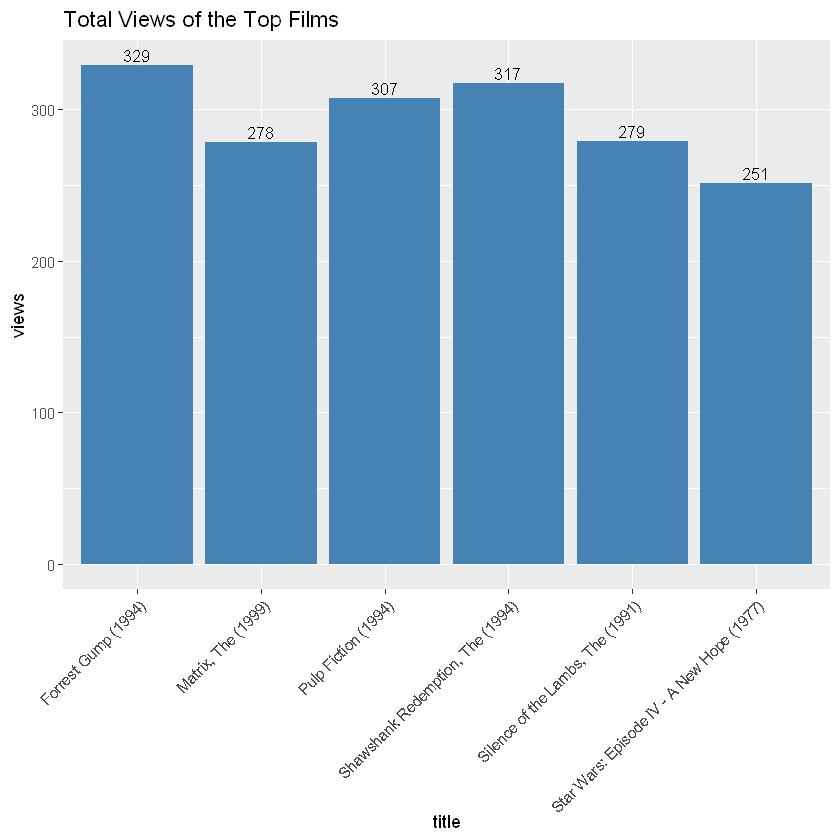

In [14]:
# Visualize a bar plot of the total number of views of the top films using ggplot
ggplot(table_views[1:6, ], aes(x = title, y = views)) +
  geom_bar(stat="identity", fill = 'steelblue') +
  geom_text(aes(label=views), vjust=-0.3, size=3.5) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("Total Views of the Top Films")

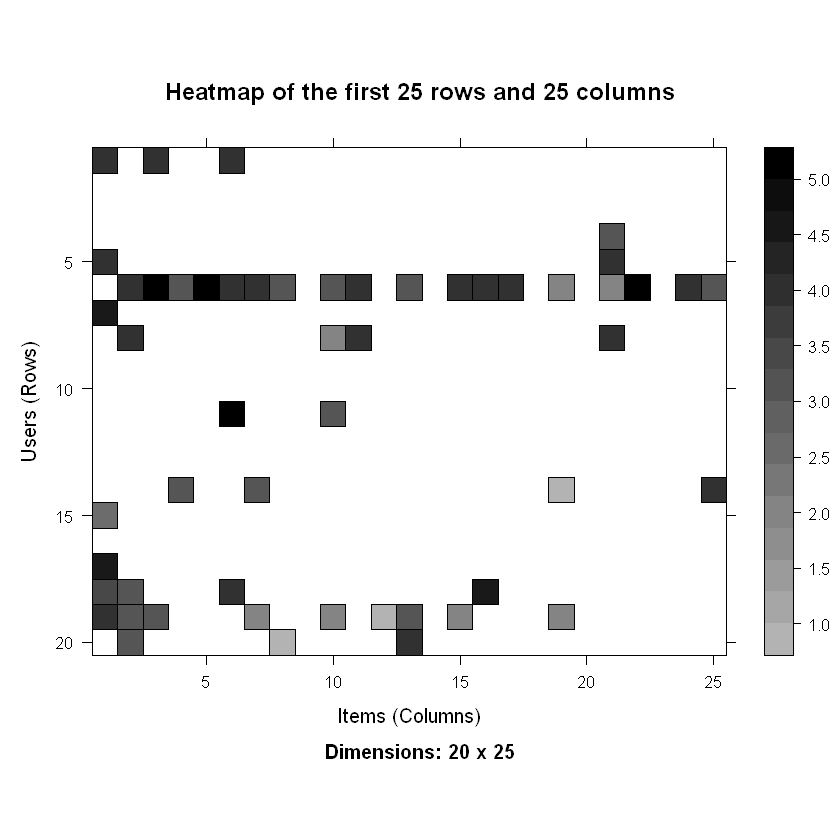

In [15]:
# Visualize a heatmap (25 x 25) of the movie ratings
image(ratingMatrix[1:20, 1:25], axes = FALSE, main = "Heatmap of the first 25 rows and 25 columns")

In [16]:
# Set the threshold for the minimum number of users who have rated a film as 50
movie_ratings <- ratingMatrix[rowCounts(ratingMatrix) > 50, colCounts(ratingMatrix) > 50]

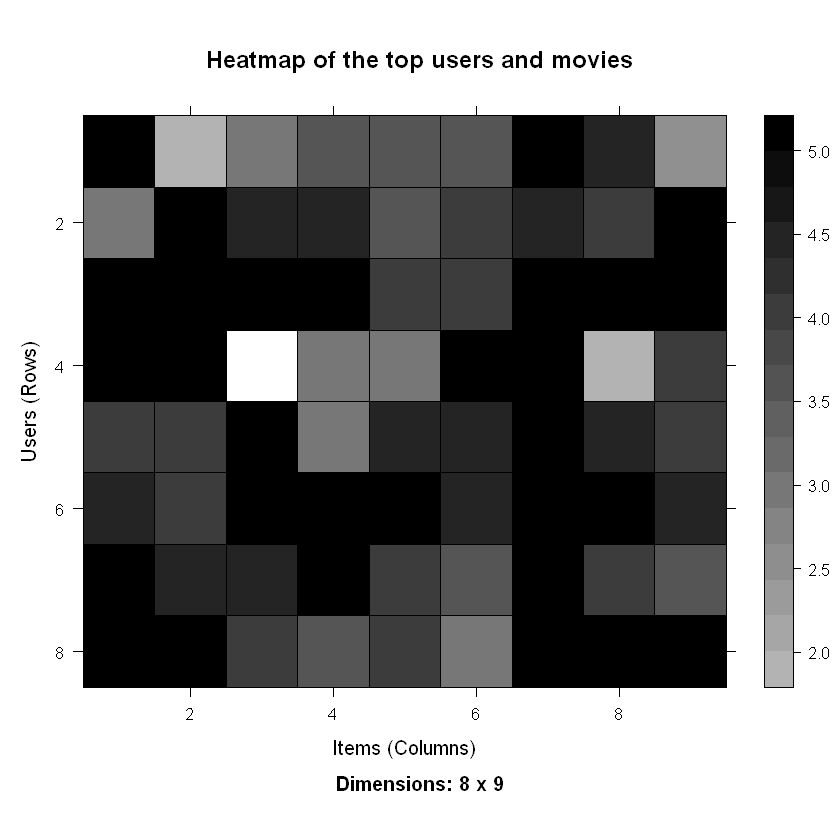

In [17]:
# Delinate our matrix of relevant users
minimum_movies<- quantile(rowCounts(movie_ratings), 0.98)
minimum_users <- quantile(colCounts(movie_ratings), 0.98)
image(movie_ratings[rowCounts(movie_ratings) > minimum_movies, colCounts(movie_ratings) > minimum_users], main = "Heatmap of the top users and movies")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


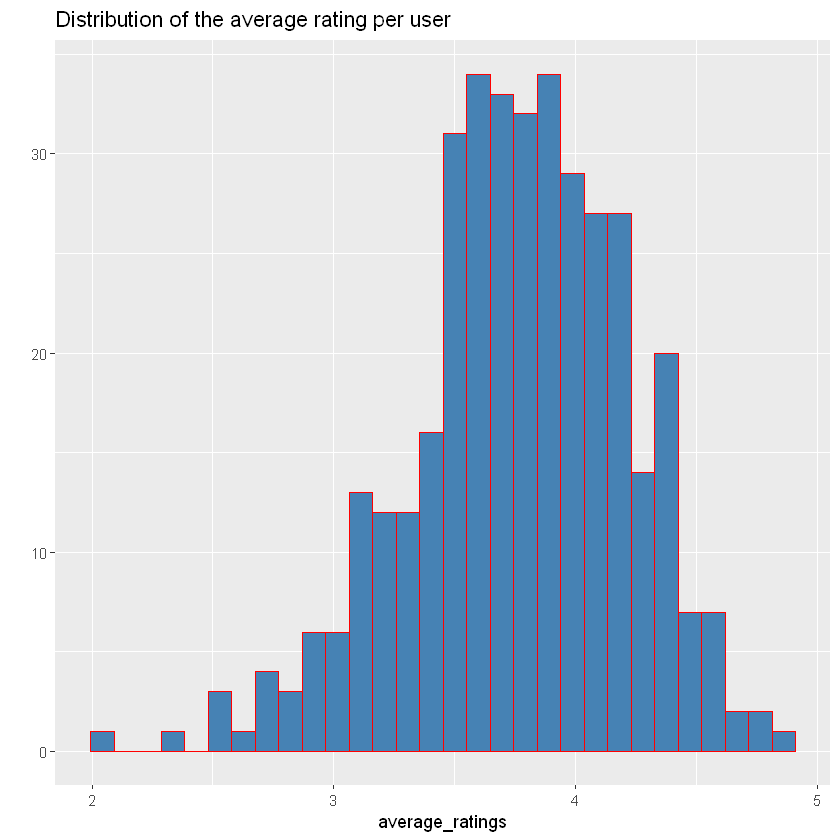

In [18]:
# Visualize the distribution of the average ratings per user
average_ratings <- rowMeans(movie_ratings)
qplot(average_ratings, fill=I("steelblue"), col=I("red")) + ggtitle("Distribution of the average rating per user")

[1] 0

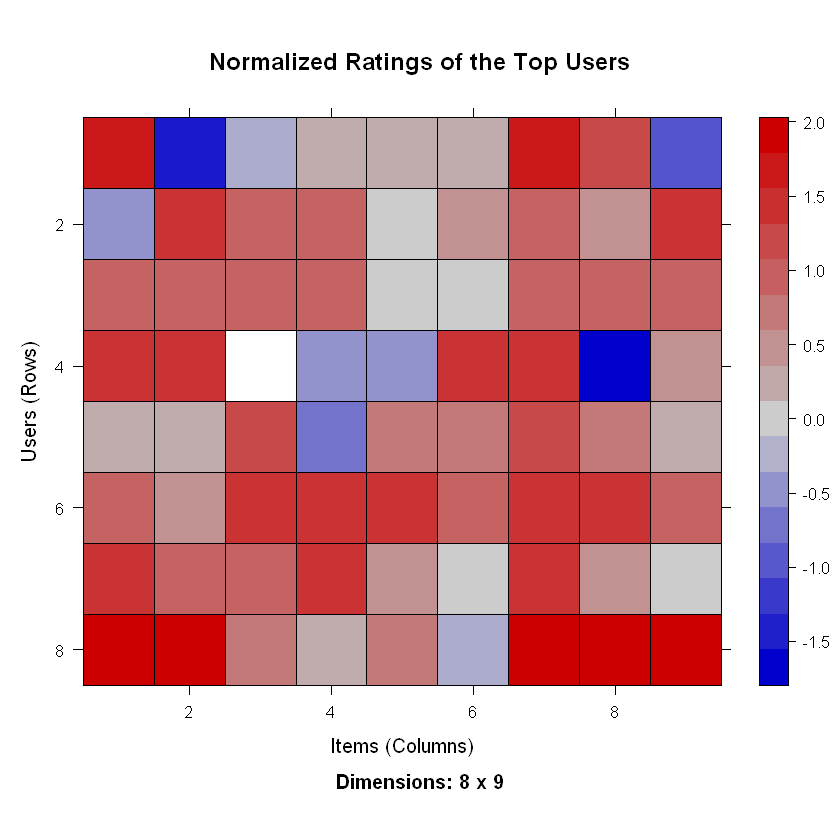

In [19]:
# Normalize the average values of the ratings column to 0
normalized_ratings <- normalize(movie_ratings)
sum(rowMeans(normalized_ratings) > 0.00001)
image(normalized_ratings[rowCounts(normalized_ratings) > minimum_movies, colCounts(normalized_ratings) > minimum_users],main = "Normalized Ratings of the Top Users")
binary_minimum_movies <- quantile(rowCounts(movie_ratings), 0.95)
binary_minimum_users <- quantile(colCounts(movie_ratings), 0.95)

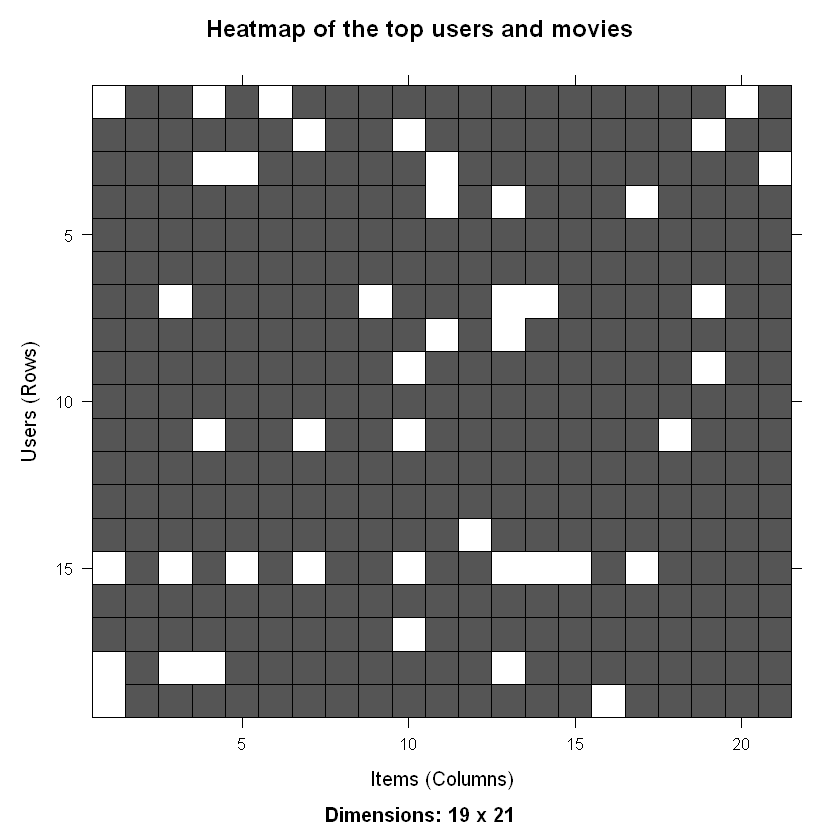

In [20]:
# Binarize the data by defining a matrix: movies_watched <- binarize(movie_ratings, minRating = 1)
good_rated_films <- binarize(movie_ratings, minRating = 3)
image(good_rated_films[rowCounts(movie_ratings) > binary_minimum_movies,
colCounts(movie_ratings) > binary_minimum_users], main = "Heatmap of the top users and movies")


In [21]:
# Build filtering system by splitting the dataset into 80% Training and 20% Testing
sampled_data<- sample(x = c(TRUE, FALSE), size = nrow(movie_ratings), replace = TRUE, prob = c(0.8, 0.2))
training_data <- movie_ratings[sampled_data, ]
testing_data <- movie_ratings[!sampled_data, ]


In [22]:
# Identify the k most similar items and store their number with the default cosine method
recommendation_system <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
recommendation_system$IBCF_realRatingMatrix$parameters

$k
[1] 30

$method
[1] "Cosine"

$normalize
[1] "center"

$normalize_sim_matrix
[1] FALSE

$alpha
[1] 0.5

$na_as_zero
[1] FALSE

In [23]:
recommen_model <- Recommender(data = training_data, method = "IBCF", parameter = list(k = 30))

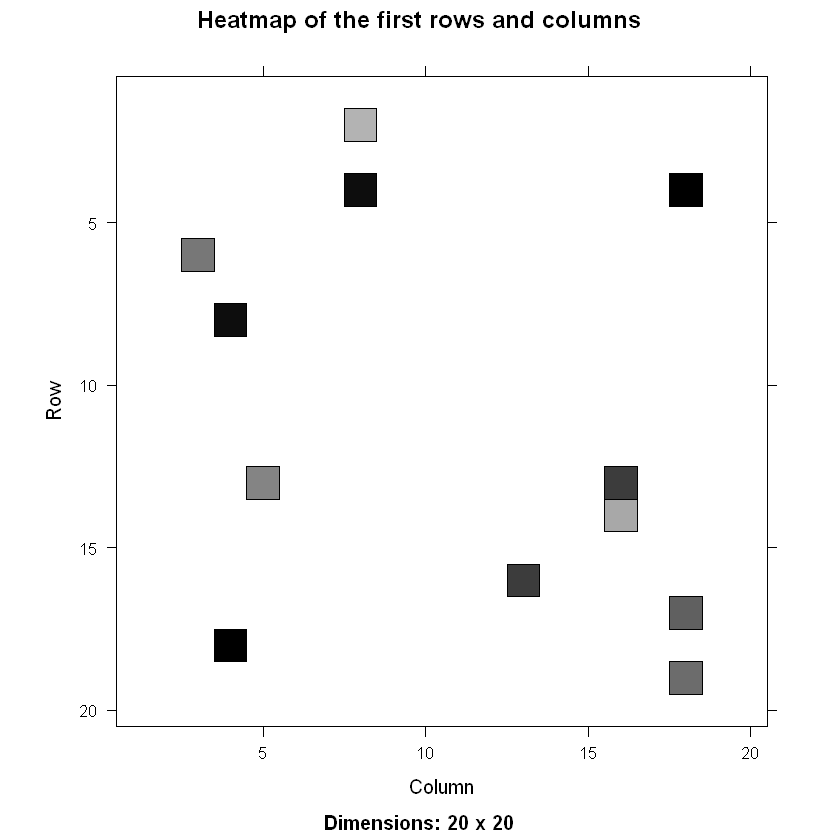

In [24]:
# getModel() to retreive the recommen_model and generate a heatmap
model_info <- getModel(recommen_model)
top_items <- 20
image(model_info$sim[1:top_items, 1:top_items], main = "Heatmap of the first rows and columns")

sum_rows
 30 
436 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


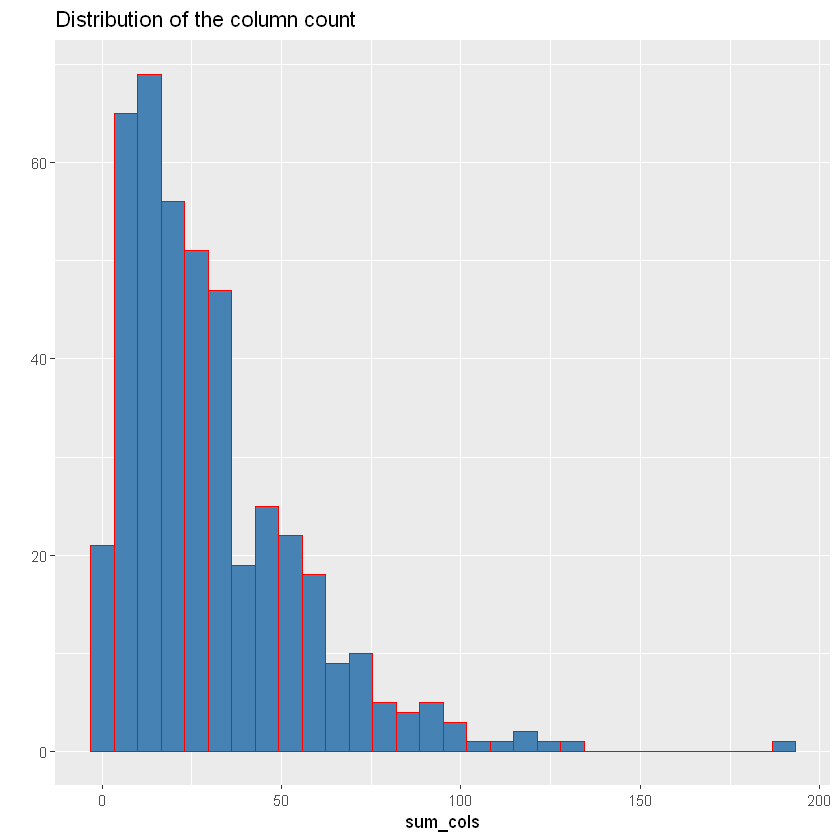

In [25]:
# Carry out the sum of rows and columns with the similarity of the objects above 0 and visualize the sum of the columns through a distribution
sum_rows <- rowSums(model_info$sim > 0)
table(sum_rows)
sum_cols <- colSums(model_info$sim > 0)
qplot(sum_cols, fill=I("steelblue"), col=I("red"))+ ggtitle("Distribution of the column count")


In [26]:
# Create top_recommendations variable to initialize to 10 specifying the number of films to each user and use predict() to identify similar items and rank tham appropriately
top_recommendations <- 10 # the number of films to recommend to each user
predicted_recommendations <- predict(object = recommen_model, newdata = testing_data, n = top_recommendations)
predicted_recommendations

Recommendations as 'topNList' with n = 10 for 75 users. 

In [27]:
user1 <- predicted_recommendations@items[[1]] # recommendation for the first user
movies_user1 <- predicted_recommendations@itemLabels[user1] # list of movies
movies_user2 <- movies_user1
for (index in 1:10){
  movies_user2[index] <- as.character(subset(movie_data, movie_data$movieId == movies_user1[index])$title)
}
movies_user2

[1] "Few Good Men, A (1992)"                                                                    
 [2] "40-Year-Old Virgin, The (2005)"                                                            
 [3] "Top Gun (1986)"                                                                            
 [4] "Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006)"
 [5] "Bourne Supremacy, The (2004)"                                                              
 [6] "Blow (2001)"                                                                               
 [7] "School of Rock (2003)"                                                                     
 [8] "Mystic River (2003)"                                                                       
 [9] "Knocked Up (2007)"                                                                         
[10] "Beauty and the Beast (1991)"

## References
## 1. Data Flair. (2019, July 31). Machine learning project - data science movie recommendation system project in R. DataFlair. Retrieved May 19, 2022, from https://data-flair.training/blogs/data-science-r-movie-recommendation/ 